# Google Envir

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


Mounted at /content/gdrive


# Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import os
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import reciprocal
from tqdm import tqdm
import dill
from typing import Union
import scipy

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFE
import math
from sklearn.preprocessing import MinMaxScaler, StandardScaler , OneHotEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline, make_pipeline

#Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Ridge, Lasso


#Features selection
from sklearn.feature_selection import SelectKBest, SelectFromModel, SequentialFeatureSelector

import warnings
warnings.filterwarnings("ignore")

# Read data

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/P integrador/total_sales_clean.csv')
df=df.drop(df.columns[[0]],axis=1)
df

,date,state_id,cat_id,sell_price,value,total_sells
0,2011-01-29,CA,FOODS,4059.66,8878,3.604166e+07
1,2011-01-29,CA,HOBBIES,1470.28,1644,2.417140e+06
2,2011-01-29,CA,HOUSEHOLD,3594.69,2048,7.361925e+06
3,2011-01-30,CA,FOODS,3750.99,8593,3.223226e+07
4,2011-01-30,CA,HOBBIES,1334.13,1325,1.767722e+06
...,...,...,...,...,...,...
5808,2016-05-21,CA,HOBBIES,4105.49,2156,8.851436e+06
5809,2016-05-21,CA,HOUSEHOLD,8765.58,5201,4.558978e+07
5810,2016-05-22,CA,FOODS,9338.38,13594,1.269459e+08
5811,2016-05-22,CA,HOBBIES,4266.53,2060,8.789052e+06


# Total Sales all Categories

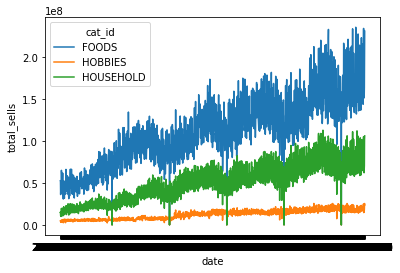

In [ ]:
sns.lineplot(data= df, x = "date", y="total_sells", hue="cat_id" )

# **HOBBIES** ✅

## DATA

In [ ]:
df_hobbies = df.query("cat_id ==  'HOBBIES'")
df_hobbies = df_hobbies.reset_index()
df_hobbies=df_hobbies.drop(df_hobbies.columns[[0]],axis=1)
df_hobbies

,date,state_id,cat_id,sell_price,value,total_sells
0,2011-01-29,CA,HOBBIES,1470.28,1644,2417140.32
1,2011-01-30,CA,HOBBIES,1334.13,1325,1767722.25
2,2011-01-31,CA,HOBBIES,1201.86,1221,1467471.06
3,2011-02-01,CA,HOBBIES,1162.82,1166,1355848.12
4,2011-02-02,CA,HOBBIES,1179.53,928,1094603.84
...,...,...,...,...,...,...
1931,2016-05-18,CA,HOBBIES,3148.27,1280,4029785.60
1932,2016-05-19,CA,HOBBIES,3378.78,1359,4591762.02
1933,2016-05-20,CA,HOBBIES,3575.31,1544,5520278.64
1934,2016-05-21,CA,HOBBIES,4105.49,2156,8851436.44


Initial Split, test 30 days

In [ ]:
new_df_hobbies, X_test, y_test= df_hobbies.iloc[:-30, :], df_hobbies.iloc[-30:,df_hobbies.columns!='total_sells'], df_hobbies.iloc[-30:, -1]

## Plots

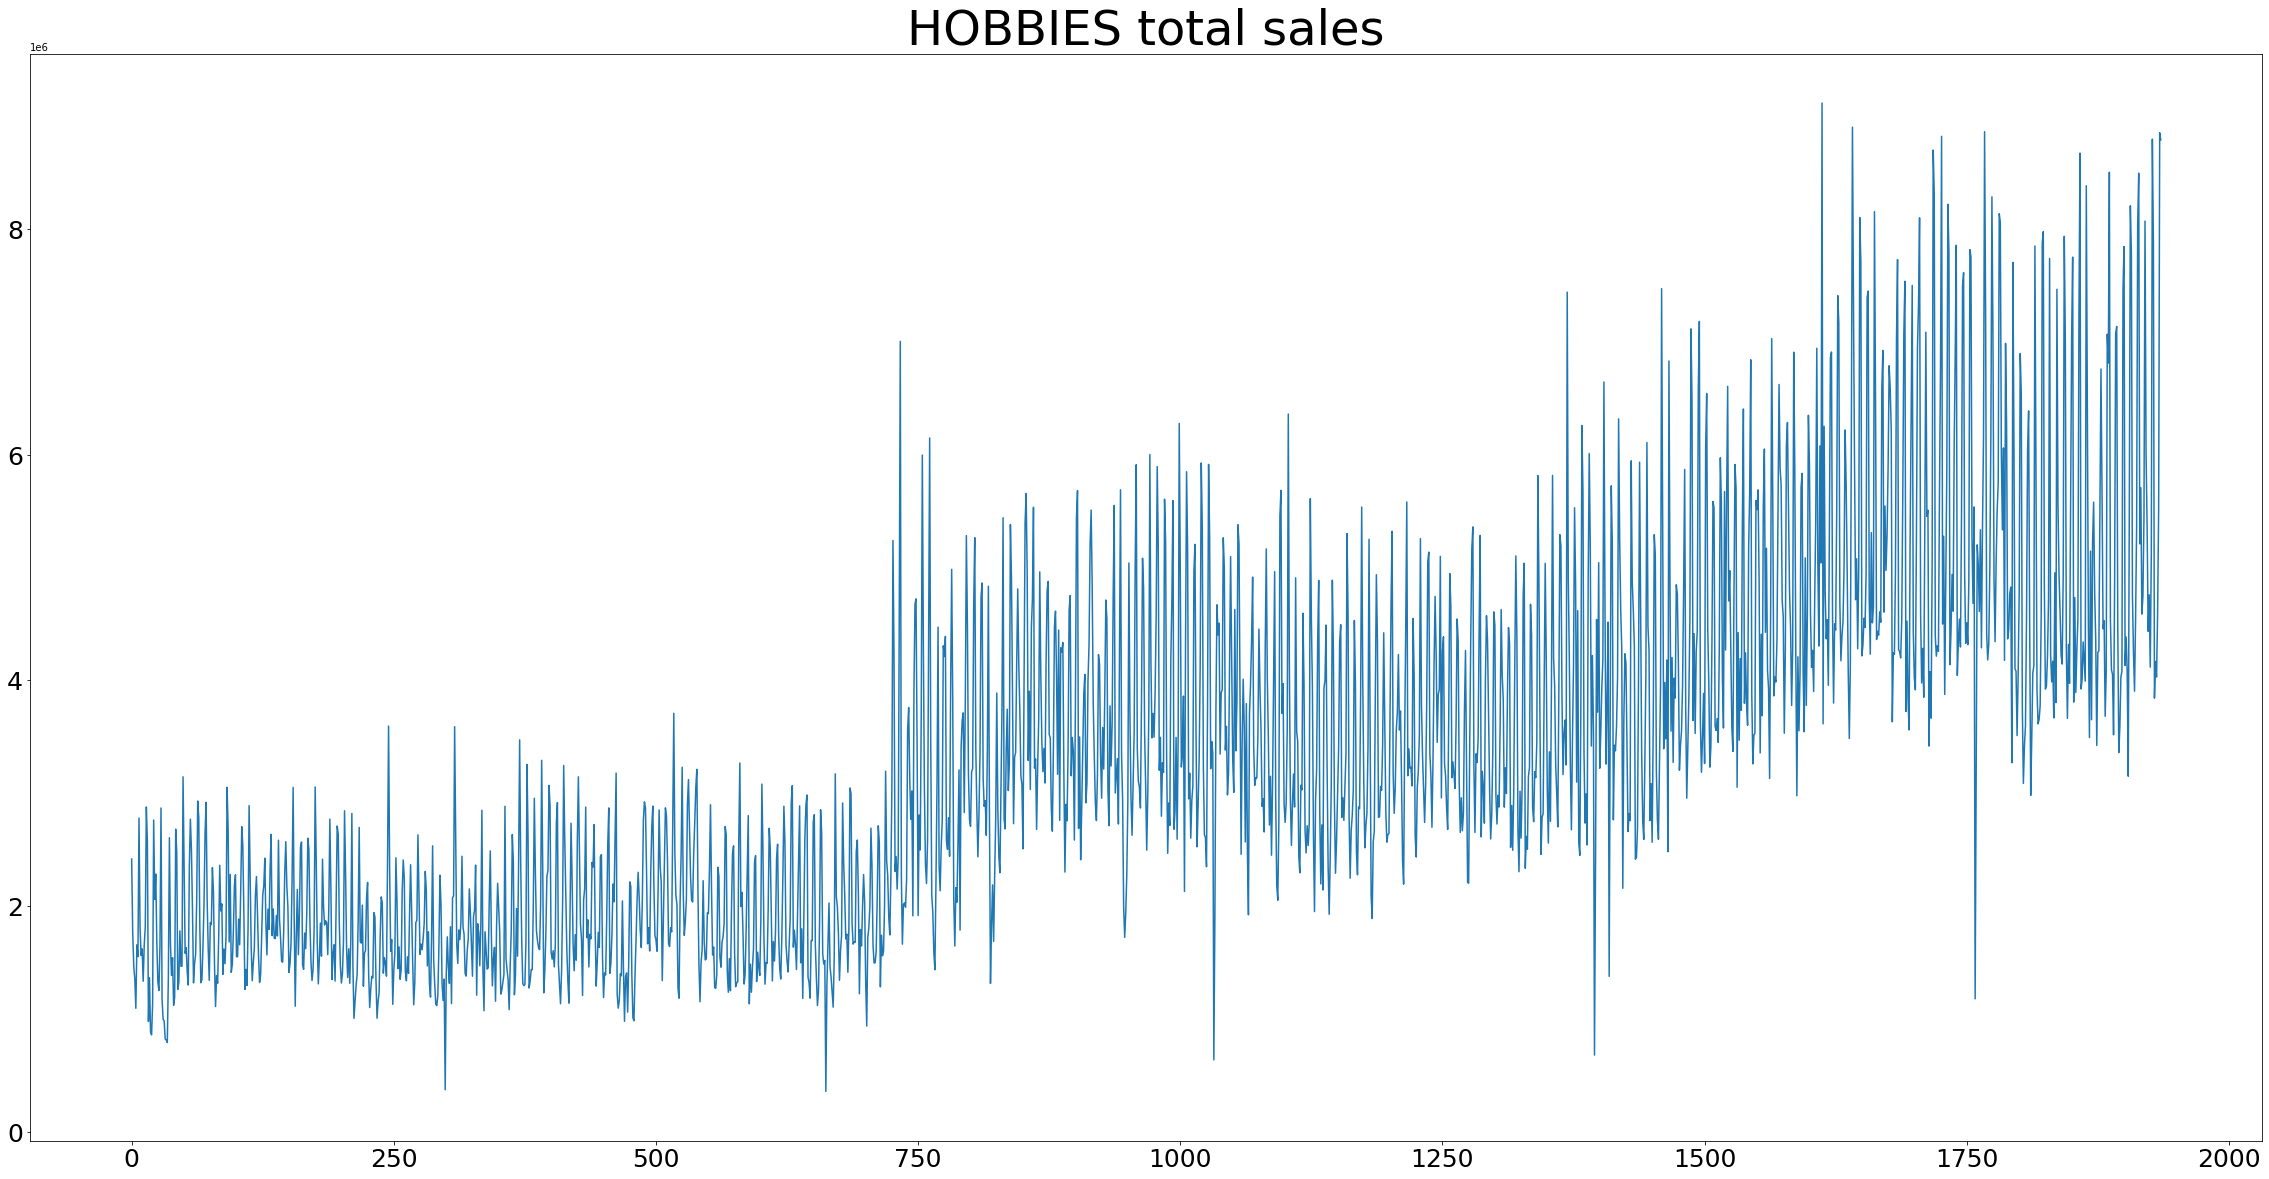

In [ ]:
plt.figure(figsize=(40, 20))
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title('HOBBIES total sales',fontsize=48)
plt.plot(df_hobbies.index,df_hobbies['total_sells'])
plt.show()

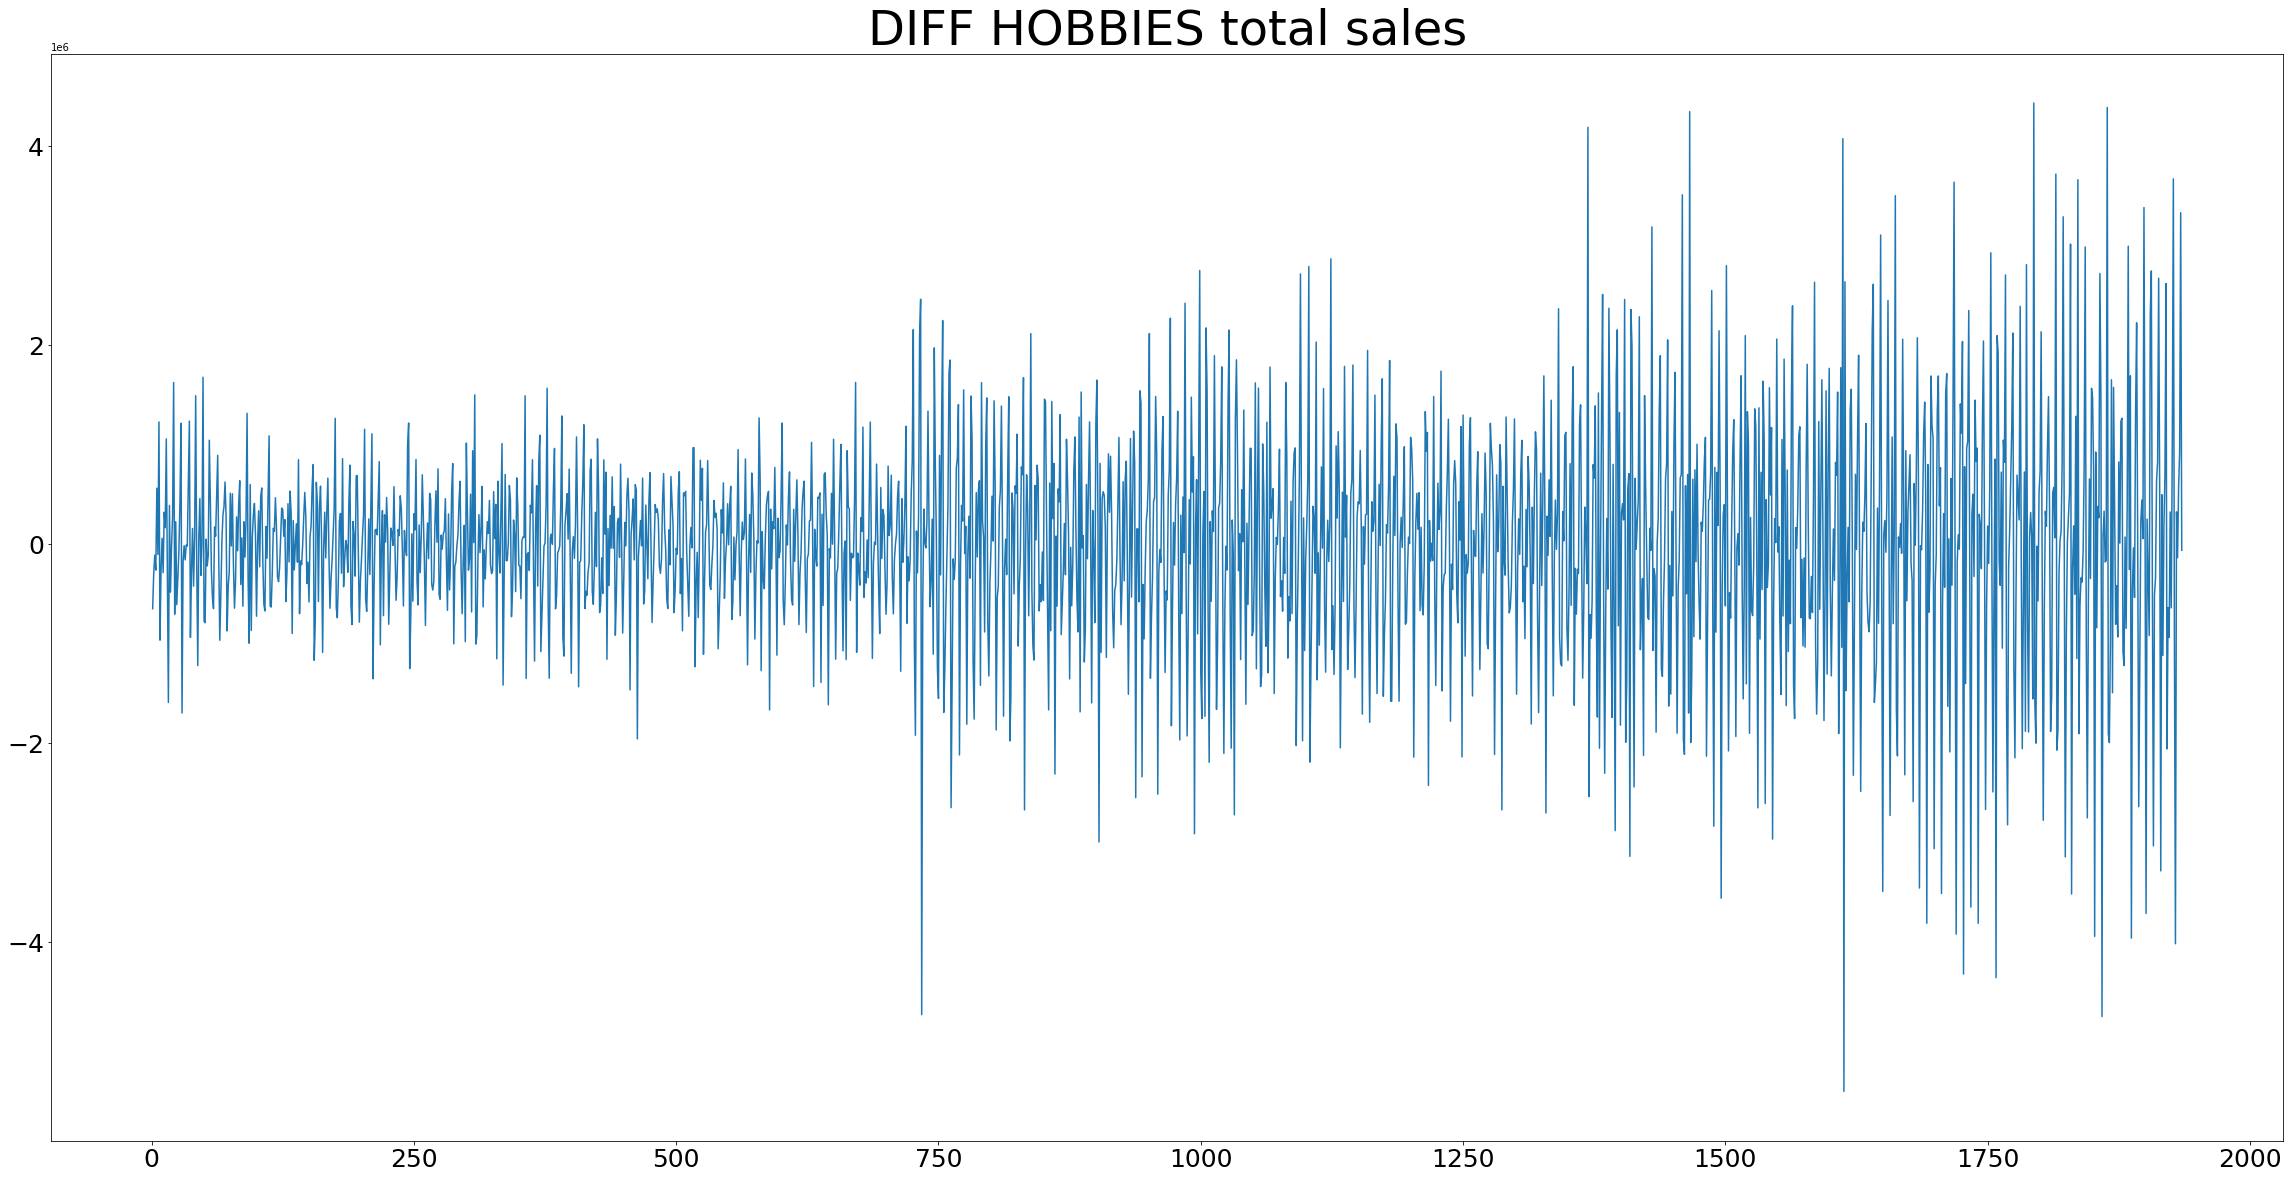

In [ ]:
plt.figure(figsize=(40, 20))
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title('DIFF HOBBIES total sales',fontsize=48)
plt.plot(df_hobbies.index, df_hobbies['total_sales_DIFF'])
plt.show()

**scale**

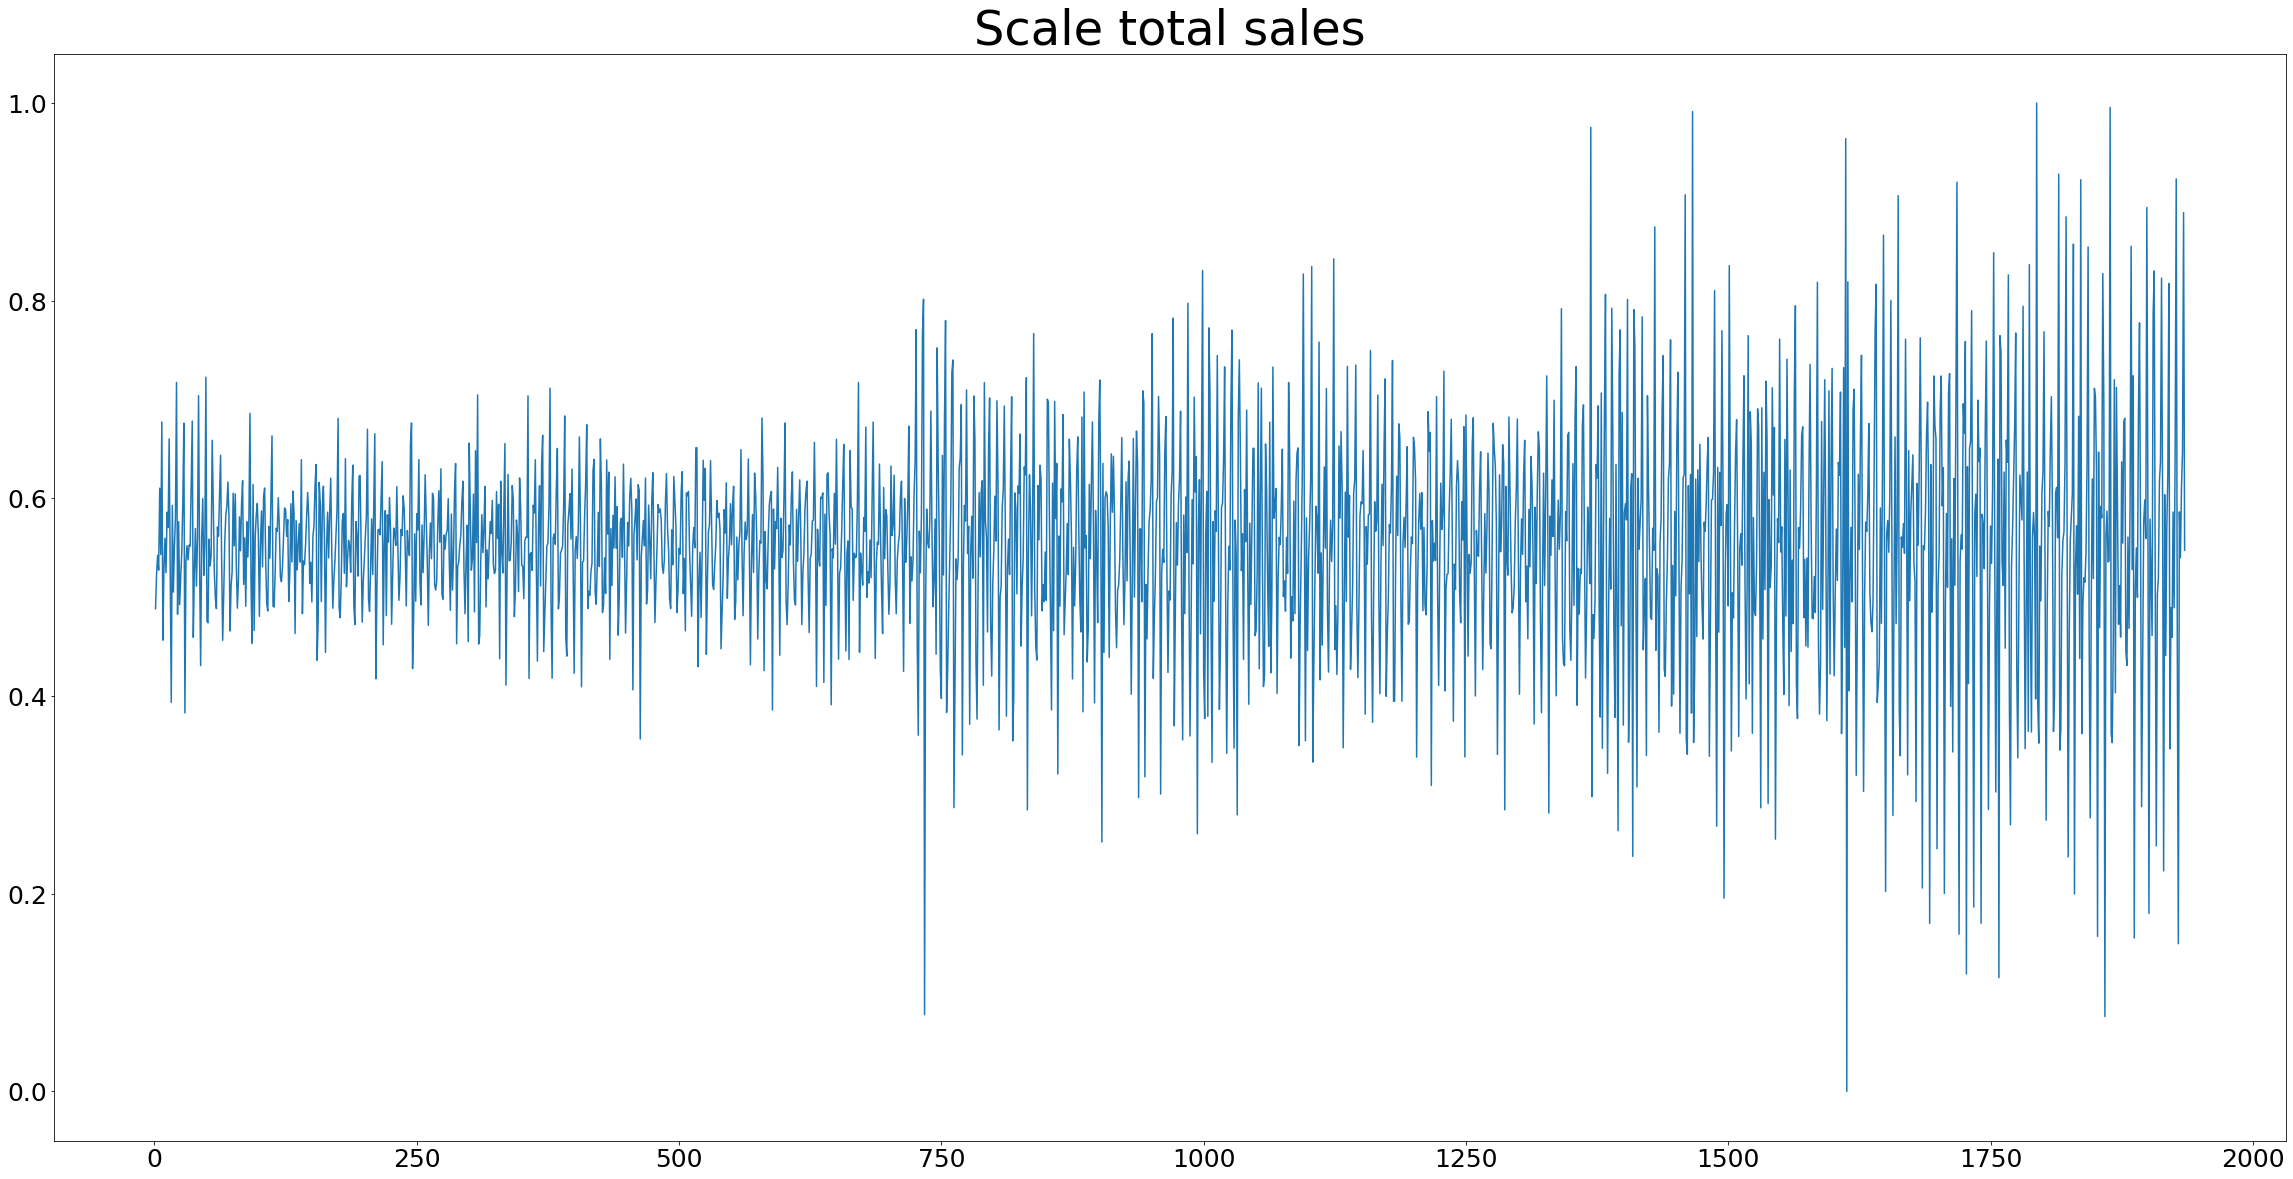

In [ ]:
plt.figure(figsize=(40, 20))
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title('Scale total sales',fontsize=48)
plt.plot(df_hobbies.index, df_hobbies['scale'])
plt.show()

## **Process DataFrame with Year, Month Ordinal and Lags**

In [ ]:
from datetime import datetime

In [ ]:
datelist=[]
for i in range(0,len(new_df_hobbies)):

  datelist.append(datetime.strptime((new_df_hobbies.loc[i,'date']), '%Y-%m-%d'))

In [ ]:
new_df_hobbies['datenew']=datelist

In [ ]:
df_hobbies_time = new_df_hobbies[['state_id', 'cat_id', 'sell_price', 'value', 'datenew', 'total_sells']]

In [ ]:
df_hobbies_time.tail()

,state_id,cat_id,sell_price,value,datenew,total_sells
1901,CA,HOBBIES,3109.07,1329,2016-04-18,4131954.03
1902,CA,HOBBIES,3021.12,1451,2016-04-19,4383645.12
1903,CA,HOBBIES,3279.32,1241,2016-04-20,4069636.12
1904,CA,HOBBIES,2580.61,1221,2016-04-21,3150924.81
1905,CA,HOBBIES,3390.29,1610,2016-04-22,5458366.90


In [ ]:
variables_list=[]
l = 30 #Lags
for i in range(0, len(new_df_hobbies.index) - l):
  variables_list.append( df_hobbies_time.iloc[i:i+l, -1].values)
df_var_Hobbies = pd.DataFrame(variables_list)
df_var_Hobbies.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,2417140.32,1767722.25,1467471.06,1355848.12,1094603.84,1656857.28,1552481.70,2780515.23,1815289.15,1562730.40,...,1137980.25,2762953.83,2058972.44,2283862.68,1675714.42,1328638.72,1252439.61,1653774.32,2869293.60,1172116.80
1,1767722.25,1467471.06,1355848.12,1094603.84,1656857.28,1552481.70,2780515.23,1815289.15,1562730.40,1621300.42,...,2762953.83,2058972.44,2283862.68,1675714.42,1328638.72,1252439.61,1653774.32,2869293.60,1172116.80,997237.67
2,1467471.06,1355848.12,1094603.84,1656857.28,1552481.70,2780515.23,1815289.15,1562730.40,1621300.42,1334510.10,...,2058972.44,2283862.68,1675714.42,1328638.72,1252439.61,1653774.32,2869293.60,1172116.80,997237.67,981076.59
3,1355848.12,1094603.84,1656857.28,1552481.70,2780515.23,1815289.15,1562730.40,1621300.42,1334510.10,1654899.40,...,2283862.68,1675714.42,1328638.72,1252439.61,1653774.32,2869293.60,1172116.80,997237.67,981076.59,822715.84
4,1094603.84,1656857.28,1552481.70,2780515.23,1815289.15,1562730.40,1621300.42,1334510.10,1654899.40,1820561.25,...,1675714.42,1328638.72,1252439.61,1653774.32,2869293.60,1172116.80,997237.67,981076.59,822715.84,812698.98


In [ ]:
Df_hobbies_final=pd.concat([df_var_Hobbies, (df_hobbies_time.loc[l:,['datenew','total_sells']].reset_index()).drop(['index'],axis=1)], ignore_index=True, axis=1,sort=False)

In [ ]:
Df_hobbies_final.set_axis(['l1','l2','l3','l4','l5','l6','l7','l8','l9','l10'
,'l11','l12','l13','l14','l15','l16','l17','l18','l19','l20',
'l21','l22','l23','l24','l25','l26','l27','l28','l29','l30',
'date','total_sales'], axis='columns', inplace=True)

In [ ]:
Df_hobbies_final.head()

,l1,l2,l3,l4,l5,l6,l7,l8,l9,l10,...,l23,l24,l25,l26,l27,l28,l29,l30,date,total_sales
0,2417140.32,1767722.25,1467471.06,1355848.12,1094603.84,1656857.28,1552481.70,2780515.23,1815289.15,1562730.40,...,2058972.44,2283862.68,1675714.42,1328638.72,1252439.61,1653774.32,2869293.60,1172116.80,2011-02-28,997237.67
1,1767722.25,1467471.06,1355848.12,1094603.84,1656857.28,1552481.70,2780515.23,1815289.15,1562730.40,1621300.42,...,2283862.68,1675714.42,1328638.72,1252439.61,1653774.32,2869293.60,1172116.80,997237.67,2011-03-01,981076.59
2,1467471.06,1355848.12,1094603.84,1656857.28,1552481.70,2780515.23,1815289.15,1562730.40,1621300.42,1334510.10,...,1675714.42,1328638.72,1252439.61,1653774.32,2869293.60,1172116.80,997237.67,981076.59,2011-03-02,822715.84
3,1355848.12,1094603.84,1656857.28,1552481.70,2780515.23,1815289.15,1562730.40,1621300.42,1334510.10,1654899.40,...,1328638.72,1252439.61,1653774.32,2869293.60,1172116.80,997237.67,981076.59,822715.84,2011-03-03,812698.98
4,1094603.84,1656857.28,1552481.70,2780515.23,1815289.15,1562730.40,1621300.42,1334510.10,1654899.40,1820561.25,...,1252439.61,1653774.32,2869293.60,1172116.80,997237.67,981076.59,822715.84,812698.98,2011-03-04,791441.52


Max, Min, Mean, median, desv, kurt

In [ ]:
#Max
Df_hobbies_final["max1M"] =  Df_hobbies_final.shift(1).rolling(30)["total_sales"].max()
Df_hobbies_final["max2M"] =  Df_hobbies_final.shift(1).rolling(60)["total_sales"].max()
Df_hobbies_final["max6M"] =  Df_hobbies_final.shift(1).rolling(180)["total_sales"].max()

#Min
Df_hobbies_final["min1M"] =  Df_hobbies_final.shift(1).rolling(30)["total_sales"].min()
Df_hobbies_final["min2M"] =  Df_hobbies_final.shift(1).rolling(60)["total_sales"].min()
Df_hobbies_final["min6M"] =  Df_hobbies_final.shift(1).rolling(180)["total_sales"].min()
#mean
Df_hobbies_final["mean1M"] =  Df_hobbies_final.shift(1).rolling(30)["total_sales"].mean()
Df_hobbies_final["mean2M"] =  Df_hobbies_final.shift(1).rolling(60)["total_sales"].mean()
Df_hobbies_final["mean6M"] =  Df_hobbies_final.shift(1).rolling(180)["total_sales"].mean()
# Std
Df_hobbies_final["std1M"] =  Df_hobbies_final.shift(1).rolling(30)["total_sales"].std()
Df_hobbies_final["std2M"] =  Df_hobbies_final.shift(1).rolling(60)["total_sales"].std()
Df_hobbies_final["std6M"] =  Df_hobbies_final.shift(1).rolling(180)["total_sales"].std()
#kurt
Df_hobbies_final["kur1M"] =  Df_hobbies_final.shift(1).rolling(30)["total_sales"].kurt()
Df_hobbies_final["kur2M"] =  Df_hobbies_final.shift(1).rolling(60)["total_sales"].kurt()
Df_hobbies_final["kur6M"] =  Df_hobbies_final.shift(1).rolling(180)["total_sales"].kurt()



In [ ]:
Df_hobbies_final=Df_hobbies_final.iloc[180:,:]

In [ ]:
Df_hobbies_final.head()

,l1,l2,l3,l4,l5,l6,l7,l8,l9,l10,...,min6M,mean1M,mean2M,mean6M,std1M,std2M,std6M,kur1M,kur2M,kur6M
180,1849251.60,1556728.46,2415429.10,1987050.30,1832846.62,1870038.69,1852415.49,1569810.02,1977041.43,2771081.84,...,791441.52,1.854509e+06,1.871394e+06,1.852849e+06,452886.348044,481603.574361,502549.618602,-0.140932,-0.150400,-0.283593
181,1556728.46,2415429.10,1987050.30,1832846.62,1870038.69,1852415.49,1569810.02,1977041.43,2771081.84,2157992.24,...,791441.52,1.886918e+06,1.894875e+06,1.862984e+06,486069.082688,493067.041343,503592.073113,-0.535654,-0.350508,-0.323034
182,2415429.10,1987050.30,1832846.62,1870038.69,1852415.49,1569810.02,1977041.43,2771081.84,2157992.24,1349171.64,...,791441.52,1.883951e+06,1.894508e+06,1.865688e+06,488419.933946,493381.234671,500125.378620,-0.553656,-0.353166,-0.313003
183,1987050.30,1832846.62,1870038.69,1852415.49,1569810.02,1977041.43,2771081.84,2157992.24,1349171.64,1576423.16,...,791441.52,1.836933e+06,1.883376e+06,1.866700e+06,503163.526752,505845.723572,498183.580204,-0.257132,-0.378135,-0.334506
184,1832846.62,1870038.69,1852415.49,1569810.02,1977041.43,2771081.84,2157992.24,1349171.64,1576423.16,1657545.56,...,791441.52,1.808931e+06,1.864972e+06,1.868557e+06,517686.562016,512281.127112,494844.262360,-0.279441,-0.336953,-0.363271


In [ ]:
yearlist=[]
for i in (Df_hobbies_final).index: #range(0,len(Df_hobbies_final)):
  yearlist.append((Df_hobbies_final.loc[i,'date']).year)
Df_hobbies_final['year']=yearlist

In [ ]:
monthlist=[]
for i in (Df_hobbies_final).index:
  monthlist.append((Df_hobbies_final.loc[i,'date']).month)
Df_hobbies_final['month']=monthlist

In [ ]:
#Df_hobbies_final=Df_hobbies_final[['l1','l2','l3','l4','l5','l6','l7','l8','l9','l10','month','year','total_sales']]
Df_hobbies_final=Df_hobbies_final[['l1','l2','l3','l4','l5','l6','l7','l8','l9','l10'
,'l11','l12','l13','l14','l15','l16','l17','l18','l19','l20',
'l21','l22','l23','l24','l25','l26','l27','l28','l29','l30',
'max1M', 'max2M','max6M','min1M', 'min2M','min6M', 'mean1M','mean2M', 'mean6M', 'std1M', 'std2M',
'std6M', 'kur1M', 'kur2M','kur6M', 'month', 'year',  'total_sales']]
Df_hobbies_final.head()

,l1,l2,l3,l4,l5,l6,l7,l8,l9,l10,...,mean6M,std1M,std2M,std6M,kur1M,kur2M,kur6M,month,year,total_sales
180,1849251.60,1556728.46,2415429.10,1987050.30,1832846.62,1870038.69,1852415.49,1569810.02,1977041.43,2771081.84,...,1.852849e+06,452886.348044,481603.574361,502549.618602,-0.140932,-0.150400,-0.283593,8,2011,2821511.26
181,1556728.46,2415429.10,1987050.30,1832846.62,1870038.69,1852415.49,1569810.02,1977041.43,2771081.84,2157992.24,...,1.862984e+06,486069.082688,493067.041343,503592.073113,-0.535654,-0.350508,-0.323034,8,2011,1467722.64
182,2415429.10,1987050.30,1832846.62,1870038.69,1852415.49,1569810.02,1977041.43,2771081.84,2157992.24,1349171.64,...,1.865688e+06,488419.933946,493381.234671,500125.378620,-0.553656,-0.353166,-0.313003,8,2011,1004885.40
183,1987050.30,1832846.62,1870038.69,1852415.49,1569810.02,1977041.43,2771081.84,2157992.24,1349171.64,1576423.16,...,1.866700e+06,503163.526752,505845.723572,498183.580204,-0.257132,-0.378135,-0.334506,8,2011,1146999.63
184,1832846.62,1870038.69,1852415.49,1569810.02,1977041.43,2771081.84,2157992.24,1349171.64,1576423.16,1657545.56,...,1.868557e+06,517686.562016,512281.127112,494844.262360,-0.279441,-0.336953,-0.363271,8,2011,1295809.21


**Standard scaler independet variables**

In [ ]:
standar = StandardScaler()
Xstandarized = standar.fit_transform(Df_hobbies_final.loc[:,Df_hobbies_final.columns!='total_sales'])

In [ ]:
dataStandarized=pd.DataFrame(Xstandarized,columns=['l1','l2','l3','l4','l5','l6','l7','l8','l9','l10'
,'l11','l12','l13','l14','l15','l16','l17','l18','l19','l20',
'l21','l22','l23','l24','l25','l26','l27','l28','l29','l30',
'max1M', 'max2M','max6M','min1M', 'min2M','min6M', 'mean1M','mean2M', 'mean6M', 'std1M', 'std2M',
'std6M', 'kur1M', 'kur2M','kur6M', 'month', 'year'])
y = Df_hobbies_final['total_sales']

Split

In [ ]:
X_train, X_valid, y_train, y_valid = dataStandarized.iloc[:-15,:], dataStandarized.iloc[-15:,:], y.iloc[:-15], y.iloc[-15:]

**Correlation Matrix**

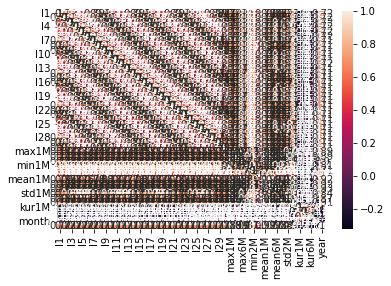

In [ ]:
sns.heatmap(Df_hobbies_final.loc[:,Df_hobbies_final.columns!='total_sales'].corr(), annot=True)
plt.show()

## Feature Engineering

### function

In [ ]:
def evaluation_models(X_train, X_valid, y_train, y_valid):
  param_grid = {'max_leaf_nodes': [10, 12,15,20], 
              'n_estimators': [100,150,200]}

  #rfgs = GridSearchCV(RandomForestRegressor(), cv=3, param_grid=param_grid)
  gbgs = GridSearchCV(GradientBoostingRegressor(), cv=3, param_grid=param_grid)
  #rfgs.fit(X_train,y_train)
  gbgs.fit(y_train,y_train)

  #rf=RandomForestRegressor(n_estimators=rfgs.best_params_['n_estimators'],max_leaf_nodes=rfgs.best_params_['max_leaf_nodes'])
  #rf.fit(X_train,y_train)
  gb=GradientBoostingRegressor(n_estimators=gbgs.best_params_['n_estimators'],max_leaf_nodes=gbgs.best_params_['max_leaf_nodes'])
  gb.fit(X_train,y_train)
  # print('MAE VALID RF')
  # print(mean_absolute_error(y_valid, rf.predict(X_valid)))
  print('MAE VALID GB')
  print(mean_absolute_error(y_valid, gb.predict(X_valid)))


In [ ]:
import warnings
warnings.filterwarnings("ignore")

### All features

In [ ]:
evaluation_models(X_train, X_valid, (y_train).values.reshape(-1,1), (y_valid).values.reshape(-1,1))

MAE VALID GB
567497.3739750369


In [ ]:
Df_hobbies_final.columns.get_indexer(['l3','l10','l24','l30','mean1M, mean2M']).tolist()

[2, 9, 23, 29, -1]

### Corr Pearson

In [ ]:
mat_spearman = Df_hobbies_final.corr('pearson')
#Correlation with output variable
cor_target = abs(mat_spearman['total_sales'])
#Selecting highly correlated features
relevant_features = (cor_target[cor_target>0.70].to_frame().T).drop('total_sales', axis=1)
(relevant_features)

,l2,l3,l4,l9,l10,l11,l16,l17,l18,l23,...,l25,l30,max1M,max2M,max6M,mean1M,mean2M,mean6M,std6M,year
total_sales,0.710152,0.843107,0.719111,0.708822,0.838794,0.718692,0.718869,0.852872,0.723281,0.71793,...,0.716778,0.748463,0.74156,0.733353,0.743826,0.764612,0.755059,0.740019,0.724871,0.710121


Evaluation

In [ ]:
evaluation_models(X_train.loc[:,list(relevant_features)], 
                  X_valid.loc[:,list(relevant_features)],
                  (y_train).values.reshape(-1,1), (y_valid).values.reshape(-1,1))

MAE VALID GB
586348.4831334191


### Corr Spearman

In [ ]:
mat_spearman = Df_hobbies_final.corr('spearman')
#Correlation with output variable
cor_target = abs(mat_spearman['total_sales'])
#Selecting highly correlated features
relevant_features = (cor_target[cor_target>0.75].to_frame().T).drop('total_sales', axis=1)
(relevant_features)

,l2,l3,l4,l9,l10,l11,l16,l17,l18,l23,l24,l25,l30,max1M,max6M,mean1M,mean2M,mean6M,year
total_sales,0.759496,0.852006,0.759751,0.761586,0.849255,0.762627,0.767229,0.866149,0.772324,0.76649,0.866491,0.769692,0.802626,0.752715,0.751752,0.785554,0.769119,0.757081,0.755055


**Evaluation**

In [ ]:
evaluation_models(X_train.loc[:,['l2','l3','l4','l9', 'l10', 'l11','l16','l17','l18','l23','l24','l25','l30','max1M','max6M','mean1M','mean2M','mean6M','year']], 
                  X_valid.loc[:,['l2','l3','l4','l9', 'l10', 'l11','l16','l17','l18','l23','l24','l25','l30','max1M','max6M','mean1M','mean2M','mean6M','year']], 
                  (y_train).values.reshape(-1,1), 
                  (y_valid).values.reshape(-1,1))

MAE VALID GB
605421.369661514


### RF Feature import

In [ ]:
rf = RandomForestRegressor(random_state=123)

rf.fit(dataStandarized,y)

RandomForestRegressor(random_state=123)

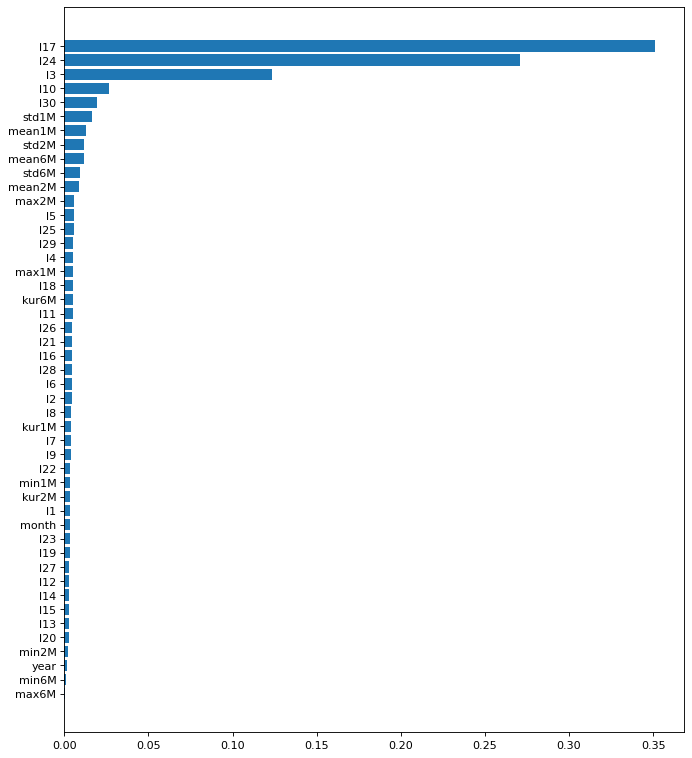

In [ ]:
f_i = list(zip(X_train.columns,rf.feature_importances_))
f_i.sort(key = lambda x : x[1])

figure(figsize=(8, 6), dpi=80)
figure(figsize=(10, 12), dpi=80)
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])

plt.show()

In [ ]:
pd.DataFrame(rf.feature_importances_,columns=['Features']).sort_values(
   by="Features",ascending=False)

,Features
16,0.350936
23,0.270611
2,0.123652
9,0.026602
29,0.019427
39,0.016745
36,0.012766
40,0.011640
38,0.011628
41,0.009611


**Evaluation**

In [ ]:
evaluation_models(X_train.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']], X_valid.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']], (y_train).values.reshape(-1,1), (y_valid).values.reshape(-1,1))

MAE VALID GB
548057.2820278466


### Recursive Elimination

features = 5

In [ ]:
estimator = RandomForestRegressor(max_leaf_nodes= 12, max_features=2, n_estimators=100, random_state=123)
selector = RFE(estimator, n_features_to_select=7 ,step=1)
selector = selector.fit(dataStandarized, y.values)
print(selector.support_)
print(selector.ranking_)

[False False  True False False False False False False  True False False
 False False False False  True False False False False False False  True
 False False False False False  True False False False False False False
  True False  True False False False False False False False False]
[34 11  1 17 31 20 22 18  7  1 14 26 29 32 36 13  1  6 19 27 37 33 10  1
  9 25 28 30 24  1  5  8  2 23 21 35  1  3  1 15  4 12 41 39 38 40 16]


In [ ]:
ind =np.nonzero(selector.support_)[0]


In [ ]:
X_valid.iloc[:,ind.tolist()].head()

,l3,l10,l17,l24,l30,mean1M,mean6M
1681,0.386770,1.164356,1.322349,2.312662,0.050013,1.276855,1.645109
1682,3.193543,1.389414,2.127434,2.150190,0.892909,1.290710,1.634553
1683,1.976329,0.875208,1.439059,3.225204,2.302985,1.370033,1.642191
1684,0.700669,0.609667,0.662805,0.708285,2.343359,1.455644,1.649877
1685,0.066929,0.013786,0.708227,0.422758,0.670031,1.349769,1.654966


Evaluation

In [ ]:
evaluation_models(X_train.iloc[:,ind.tolist()], X_valid.iloc[:,ind.tolist()], (y_train).values.reshape(-1,1), (y_valid).values.reshape(-1,1))

MAE VALID GB
558468.2024788124


features = 3

In [ ]:
estimator = RandomForestRegressor(max_leaf_nodes= 12, max_features=2, n_estimators=100, random_state=123)
selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(dataStandarized, y.values)
print(selector.support_)
print(selector.ranking_)

[False False False  True  True False False False False  True False False]
[ 9  6  2  1  1  4  7  8  5  1 10  3]


In [ ]:
evaluation_models(X_train.iloc[:,[3,4,9]], X_valid.iloc[:,[3,4,9]], (y_train).values.reshape(-1,1), (y_valid).values.reshape(-1,1))

MAE VALID RF
499324.79712458135
MAE VALID GB
494394.4652334016


### Backward "Sequential feature selection"

In [ ]:
#Primera iteración
sfs = SequentialFeatureSelector(Lasso(alpha=0.001))
sfs.fit(dataStandarized, y)
ind =np.nonzero(sfs.get_support())[0]
print(sfs.get_support())
Xstandarized[:,ind].shape

[False False  True  True False False False  True  True  True  True  True
 False  True False False  True  True False  True  True  True False  True
 False False False  True False  True  True  True  True  True False  True
  True False False False False False False False False False  True]


(1696, 23)

In [ ]:
X_valid.iloc[:,ind.tolist()].columns

Index(['l3', 'l4', 'l8', 'l9', 'l10', 'l11', 'l12', 'l14', 'l17', 'l18', 'l20',
       'l21', 'l22', 'l24', 'l28', 'l30', 'max1M', 'max2M', 'max6M', 'min1M',
       'min6M', 'mean1M', 'year'],
      dtype='object')

In [ ]:
evaluation_models(X_train.iloc[:,ind.tolist()], X_valid.iloc[:,ind.tolist()], (y_train).values.reshape(-1,1), (y_valid).values.reshape(-1,1))

MAE VALID GB
633932.7146756314


###

## **Models**,  **Best selection features: RF feature importance: l17, l24, l3, l10, l30,  std1M,  mean1M, std2M, mean6M**

### RIDGE and LASSO

In [ ]:
# Definamos pipelines de scikit-learn con nuestros modelos base:

ridge_base = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('scaler', StandardScaler()),
    ('regressor', Ridge(max_iter=1e4))  ])

lasso_base = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('scaler', StandardScaler()),
    ('regressor', Lasso(max_iter=1e4))  ])

In [ ]:
param_distributions = {
    'poly__degree': list(range(2, 3)),
    'regressor__alpha': reciprocal(1e-5, 1e2)  }

In [ ]:
ridge = RandomizedSearchCV(
    ridge_base,
    cv=3,     param_distributions=param_distributions,
    n_iter=200,     random_state = 123 )

lasso = RandomizedSearchCV(
    lasso_base,     cv=3,
    param_distributions=param_distributions,
    n_iter=200,     random_state = 123 )

In [ ]:
%%time
#ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

In [ ]:
# Best Hyperparameters
#ridge.best_params_
lasso.best_params_

In [ ]:
print('RIDGE Model')
print(f'MAE Train: {ridge.score(X_train, y_train)}')
print(f'MAE Valid: {mean_absolute_error(y_valid, ridge.predict(X_valid))}','\n')
print('LASSO Model')
print(f'MAE Train: {lasso.score(X_train, y_train)}')
print(f'MAE Valid: {mean_absolute_error(y_valid, lasso.predict(X_valid))}','\n')

MAE Train Ridge (5;0.02) 

481536.76750661514
MAE Test Ridge (5;0.02)
503818.0347216157


------------------------------------------------------------------------------------------

###kNN

In [ ]:
knn = KNeighborsRegressor()
# parameters i.e. k neighbors list
parameters = {'n_neighbors':range(1,50)}
    
# Training the model
model = GridSearchCV(knn, param_grid = parameters, cv=5)
model.fit(X_train.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']], y_train)
print('Best value of k is ',model.best_params_)

Best value of k is  {'n_neighbors': 32}


In [ ]:
knn = KNeighborsRegressor(n_neighbors=32)
knn.fit(X_train.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']], y_train)

KNeighborsRegressor(n_neighbors=32)

In [ ]:
print('MAE Train:', mean_absolute_error(y_train, knn.predict(X_train.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']]) ),'\n')
print('MAE valid:', mean_absolute_error(y_valid, knn.predict(X_valid.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']]) ),'\n')


MAE Train: 458995.7160118606 

MAE valid: 498964.2942291667 



**Pearson Correlation**

In [ ]:
knn = KNeighborsRegressor()
# parameters i.e. k neighbors list
parameters = {'n_neighbors':range(1,50)}
    
# Training the model
model = GridSearchCV(knn, param_grid = parameters, cv=5)
model.fit(X_train.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']], y_train)
print('Best value of k is ',model.best_params_)
knn = KNeighborsRegressor(n_neighbors=model.best_params_['n_neighbors'])
knn.fit(X_train.loc[:,list(relevant_features)], y_train)
print('MAE Train:', mean_absolute_error(y_train, knn.predict(X_train.loc[:,list(relevant_features)]) ),'\n')
print('MAE valid:', mean_absolute_error(y_valid, knn.predict(X_valid.loc[:,list(relevant_features)]) ),'\n')


Best value of k is  {'n_neighbors': 32}
MAE Train: 455612.1430478509 

MAE valid: 595948.0147708332 



### RF

In [ ]:
random_grid = {'n_estimators': [30,50,100,150],
               'max_features': [6,7,8,9],  'max_leaf_nodes': [15,20,22,25]}
rf = RandomForestRegressor()
rf_GS = GridSearchCV(estimator = rf, param_grid = random_grid, cv = 4)
# Fit the random search model
rf_GS.fit(X_train.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']], y_train)
print('Best parameters ',rf_GS.best_params_)

Best parameters  {'max_features': 6, 'max_leaf_nodes': 22, 'n_estimators': 150}


In [ ]:
rf = RandomForestRegressor( n_estimators = rf_GS.best_params_['n_estimators'], max_features= rf_GS.best_params_['max_features'], max_leaf_nodes= rf_GS.best_params_['max_leaf_nodes'])
rf.fit(X_train.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']], y_train)

RandomForestRegressor(max_features=6, max_leaf_nodes=22, n_estimators=150)

In [ ]:
print('MAE Train:', mean_absolute_error(y_train, rf.predict(X_train.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']]) ),'\n')
print('MAE valid:', mean_absolute_error(y_valid, rf.predict(X_valid.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']]) ))

MAE Train: 428888.496128275 

MAE valid: 563891.1765303132


### Gradient Boosting

In [ ]:
param_grid = {'n_estimators': [50,100,150,200],
               'max_features': [6,7,8,9],  'max_leaf_nodes': [10,12,15,20]}
gbgs = GridSearchCV(GradientBoostingRegressor(), cv=4, param_grid=param_grid)
gbgs.fit(X_train.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']], y_train)

GridSearchCV(cv=4, estimator=GradientBoostingRegressor(),
             param_grid={'max_features': [6, 8, 9],
                         'max_leaf_nodes': [10, 12, 15, 20],
                         'n_estimators': [50, 100, 150, 200]})

In [ ]:
gb=GradientBoostingRegressor(n_estimators = gbgs.best_params_['n_estimators'], max_features= gbgs.best_params_['max_features'], max_leaf_nodes=gbgs.best_params_['max_leaf_nodes'])
gb.fit(X_train.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']], y_train)

GradientBoostingRegressor(max_features=6, max_leaf_nodes=12, n_estimators=50)

In [ ]:
print('MAE Train:', mean_absolute_error(y_train, gb.predict(X_train.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']]) ),'\n')
print('MAE valid:', mean_absolute_error(y_valid, gb.predict(X_valid.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']]) ))

MAE Train: 413914.5257296372 

MAE valid: 584023.9910193294


### SVR

In [ ]:
param_grid = {'kernel': ['poly'], 'C': [10,100,500,1000,5000], 'degree': range(2,6)} 
  
grid = GridSearchCV( SVR(), param_grid, cv = 4)
grid.fit(X_train.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']], y_train)
grid.best_params_

{'C': 1000, 'degree': 3, 'kernel': 'poly'}

In [ ]:
regressor = SVR(kernel ='poly', C=grid.best_params_['C'], degree=grid.best_params_['degree'] )
# fit the model on the data
regressor.fit(X_train.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']], y_train)

SVR(C=1000, kernel='poly')

In [ ]:
print('MAE Train:', mean_absolute_error(y_train, regressor.predict(X_train.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']]) ),'\n')
print('MAE valid:', mean_absolute_error(y_valid, regressor.predict(X_valid.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']]) ),'\n')


MAE Train: 763292.3291559427 

MAE valid: 634416.2358027374 



### RF-kNN : JJ

In [ ]:
from tqdm import tqdm
import dill
from typing import Union
import scipy


#### Functions

In [ ]:
class RF_KNN:
    def __init__(
        self,
        n_trees: int = 100,
        max_leaf_nodes: int = 7,
        min_samples_leaf: int = 10,
        max_features: int = 2,
        n_neighbors: int = 7,
        p: int =2 ):
      
        self.n_trees = n_trees
        self.max_leaf_nodes = max_leaf_nodes
        self.min_samples_leaf= min_samples_leaf
        self.max_features= max_features
        self.n_neighbors = n_neighbors
        self.p = p
        self.rf = RandomForestRegressor(
            n_estimators=self.n_trees,
            max_leaf_nodes=self.max_leaf_nodes,
            min_samples_leaf=self.min_samples_leaf, max_features = self.max_features
        )
        self.scaler = MinMaxScaler()

    def get_idxs_dict(self, leaves: np.ndarray):
        idxs_dict = {}

        for tree in range(self.n_trees):
            col = leaves[:, tree]

            for leaf in np.unique(col):
                # Get the indices of the data samples in each tree-leaf pair:
                idxs_dict[(tree, leaf)] = np.flatnonzero(col == leaf)
        
        return idxs_dict

    def fit(
        self,
        X: Union[np.ndarray, pd.DataFrame],
        y: Union[np.ndarray, pd.DataFrame],
    ):
        # Turn data to numpy arrays if they come as DataFrames or series:

        if isinstance(X, (pd.DataFrame, pd.Series)):
            X = X.values
        
        if isinstance(y, (pd.DataFrame, pd.Series)):
            y = y.values

        # Normalize the data:
       # X = self.scaler.fit_transform(X)

        self.rf.fit(X, y)
        leaves = self.rf.apply(X)
        idxs_dict = self.get_idxs_dict(leaves)

        self.knn_dict = {}
        knn_predictions = [[] for _ in range(len(X))]
        
        print("Training the kNN classifiers:")
        for (tree, leaf), idxs in tqdm(idxs_dict.items()):
            knn = KNeighborsRegressor(self.n_neighbors, p=self.p)
            knn.fit(X[idxs], y[idxs])
            self.knn_dict[(tree, leaf)] = knn

            for i, pred in zip(idxs, knn.predict(X[idxs])):
                knn_predictions[i].append(pred)
        
        # Get predictions:
        y_pred = scipy.mean(knn_predictions, axis=1)

        # Show performance on training set:
       # print(classification_report(y, y_pred,digits=4))

    def predict(self, X: Union[np.ndarray, pd.DataFrame]):
        # Turn data to numpy arrays if they come as DataFrames or series:
        if isinstance(X, (pd.DataFrame, pd.Series)):
            X = X.values

        # Normalize the data:
        #X = self.scaler.transform(X)

        leaves = self.rf.apply(X)
        idxs_dict = self.get_idxs_dict(leaves)

        knn_predictions = [[] for _ in range(len(X))]
        
        print("Predicting with the kNN classifiers:")
        for (tree, leaf), idxs in tqdm(idxs_dict.items()):
            knn = self.knn_dict[(tree, leaf)]

            for i, pred in zip(idxs, knn.predict(X[idxs])):
                knn_predictions[i].append(pred)
        
        # Return predictions:
        return scipy.mean(knn_predictions, axis=1)

In [ ]:
scaler = MinMaxScaler()

#### Prediction

In [ ]:
rf_knn = RF_KNN(
    n_trees = 45,
    max_leaf_nodes = 2, max_features=9,  n_neighbors = 34)

In [ ]:
%%time
rf_knn.fit(X_train.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']], y_train)

Training the kNN classifiers:


100%|██████████| 90/90 [00:01<00:00, 56.83it/s]


CPU times: user 1.82 s, sys: 20.1 ms, total: 1.84 s
Wall time: 2.29 s


In [ ]:
print('MAE Train:', mean_absolute_error(y_train, rf_knn.predict(X_train.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']]) ),'\n')
print('MAE valid:', mean_absolute_error(y_valid, rf_knn.predict(X_valid.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']]) ),'\n')


Predicting with the kNN classifiers:


100%|██████████| 90/90 [00:01<00:00, 51.19it/s]


MAE Train: 459432.09923509974 

Predicting with the kNN classifiers:


100%|██████████| 83/83 [00:00<00:00, 705.85it/s]

MAE valid: 493392.91871982615 



## **Models**,  'X and Y Scaled' , **Best selection features: RF feature importance: l17, l24, l3, l10, l30,  std1M,  mean1M, std2M, mean6M**

### Scaled and Split

In [ ]:
scaler  = MinMaxScaler()
Xscaled = scaler.fit_transform(Df_hobbies_final.loc[:,Df_hobbies_final.columns!='total_sales'])

In [ ]:
yscaled=scaler.fit_transform(Df_hobbies_final['total_sales'].values.reshape(-1, 1))

In [ ]:
dataScaled=pd.DataFrame(Xscaled, columns=['l1','l2','l3','l4','l5','l6','l7','l8','l9','l10'
,'l11','l12','l13','l14','l15','l16','l17','l18','l19','l20',
'l21','l22','l23','l24','l25','l26','l27','l28','l29','l30',
'max1M', 'max2M','max6M','min1M', 'min2M','min6M', 'mean1M','mean2M', 'mean6M', 'std1M', 'std2M',
'std6M', 'kur1M', 'kur2M','kur6M', 'month', 'year'])

Split

In [ ]:
X_trainScaled, X_validScaled, y_trainScaled, y_validScaled = dataScaled.iloc[:-15,:], dataScaled.iloc[-15:,:], yscaled[:-15], yscaled[-15:]

### RIDGE and LASSO

In [ ]:
# Definamos pipelines de scikit-learn con nuestros modelos base:

ridge_base = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('scaler', StandardScaler()),
    ('regressor', Ridge(max_iter=1e4))  ])

lasso_base = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('scaler', StandardScaler()),
    ('regressor', Lasso(max_iter=1e4))  ])

In [ ]:
param_distributions = {
    'poly__degree': list(range(2, 3)),
    'regressor__alpha': reciprocal(1e-5, 1e2)  }

In [ ]:
ridge = RandomizedSearchCV(
    ridge_base,
    cv=3,     param_distributions=param_distributions,
    n_iter=200,     random_state = 123 )

lasso = RandomizedSearchCV(
    lasso_base,     cv=3,
    param_distributions=param_distributions,
    n_iter=200,     random_state = 123 )

In [ ]:
%%time
#ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

In [ ]:
# Best Hyperparameters
#ridge.best_params_
lasso.best_params_

In [ ]:
print('RIDGE Model')
print(f'MAE Train: {ridge.score(X_train, y_train)}')
print(f'MAE Valid: {mean_absolute_error(y_valid, ridge.predict(X_valid))}','\n')
print('LASSO Model')
print(f'MAE Train: {lasso.score(X_train, y_train)}')
print(f'MAE Valid: {mean_absolute_error(y_valid, lasso.predict(X_valid))}','\n')

MAE Train Ridge (5;0.02) 

481536.76750661514
MAE Test Ridge (5;0.02)
503818.0347216157


------------------------------------------------------------------------------------------

### kNN

In [ ]:
knn = KNeighborsRegressor()
# parameters i.e. k neighbors list
parameters = {'n_neighbors':range(1,50)}
    
# Training the model
model = GridSearchCV(knn, param_grid = parameters, cv=5)
model.fit(X_trainScaled.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']], y_trainScaled)
print('Best value of k is ',model.best_params_)

Best value of k is  {'n_neighbors': 24}


In [ ]:
knn = KNeighborsRegressor(n_neighbors=model.best_params_['n_neighbors'])
knn.fit(X_trainScaled.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']], y_trainScaled)

KNeighborsRegressor(n_neighbors=24)

In [ ]:
print('MAE Train:', mean_absolute_error( scaler.inverse_transform(y_trainScaled), scaler.inverse_transform(knn.predict(X_trainScaled.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']]) )),'\n')
print('MAE Valid:', mean_absolute_error( scaler.inverse_transform(y_validScaled), scaler.inverse_transform(knn.predict(X_validScaled.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']]) )),'\n')

MAE Train: 455056.4362710688 

MAE Valid: 489077.06677777774 



### RF

In [ ]:
random_grid = {'n_estimators': [30,50,100,150],
               'max_features': [6,7,8,9],  'max_leaf_nodes': [15,20,22,25]}
rf = RandomForestRegressor()
rf_GS = GridSearchCV(estimator = rf, param_grid = random_grid, cv = 4)
# Fit the random search model
rf_GS.fit(X_trainScaled.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']], y_trainScaled[:,0])
print('Best parameters ',rf_GS.best_params_)

Best parameters  {'max_features': 6, 'max_leaf_nodes': 25, 'n_estimators': 100}


In [ ]:
rf = RandomForestRegressor( n_estimators = rf_GS.best_params_['n_estimators'], max_features= rf_GS.best_params_['max_features'], max_leaf_nodes= rf_GS.best_params_['max_leaf_nodes'])
rf.fit(X_trainScaled.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']], y_trainScaled[:,0])

RandomForestRegressor(max_features=6, max_leaf_nodes=25)

In [ ]:
print('MAE Train:', mean_absolute_error( scaler.inverse_transform(y_trainScaled).reshape(-1,1), scaler.inverse_transform(rf.predict(X_trainScaled.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']]).reshape(-1,1) )),'\n')
print('MAE Valid:', mean_absolute_error( scaler.inverse_transform(y_validScaled).reshape(-1,1), scaler.inverse_transform(rf.predict(X_validScaled.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']]).reshape(-1,1) )))

MAE Train: 423522.9747857266 

MAE Valid: 527205.1003472828


### Gradient Boosting

In [ ]:
param_grid = {'n_estimators': [25,35,50,100],
               'max_features': [6,7,8,9],  'max_leaf_nodes': [15,20,23,26]}
gbgs = GridSearchCV(GradientBoostingRegressor(), cv=4, param_grid=param_grid)
gbgs.fit(X_trainScaled.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']], y_trainScaled[:,0])

GridSearchCV(cv=4, estimator=GradientBoostingRegressor(),
             param_grid={'max_features': [6, 7, 8, 9],
                         'max_leaf_nodes': [15, 20, 23, 26],
                         'n_estimators': [25, 35, 50, 100]})

In [ ]:
gb=GradientBoostingRegressor(n_estimators = gbgs.best_params_['n_estimators'], max_features= gbgs.best_params_['max_features'], max_leaf_nodes=gbgs.best_params_['max_leaf_nodes'])
gb.fit(X_trainScaled.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']], y_trainScaled[:,0])

GradientBoostingRegressor(max_features=6, max_leaf_nodes=20, n_estimators=50)

In [ ]:
print('MAE Train:', mean_absolute_error(y_train, gb.predict(X_train.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']]) ),'\n')
print('MAE valid:', mean_absolute_error(y_valid, gb.predict(X_valid.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']]) ))

MAE Train: 3427712.8672774076 

MAE valid: 5007366.389224974


### SVR

In [ ]:
param_grid = {'kernel': ['poly'], 'C': [100,500,1000,5000], 'degree': range(2,6)} 
  
grid = GridSearchCV( SVR(), param_grid, cv = 4)
grid.fit(X_trainScaled.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']], y_trainScaled[:,0])
grid.best_params_

In [ ]:
regressor = SVR(kernel ='poly', C=grid.best_params_['C'], degree=grid.best_params_['degree'] )
# fit the model on the data
regressor.fit(X_trainScaled.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']], y_trainScaled[:,0])

In [ ]:
print('MAE Train:', mean_absolute_error(y_train, regressor.predict(X_train.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']]) ),'\n')
print('MAE valid:', mean_absolute_error(y_valid, regressor.predict(X_valid.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']]) ),'\n')


MAE Train: 763292.3291559427 

MAE valid: 634416.2358027374 



### RF-kNN - JJ

#### Functions

In [ ]:
class RF_KNN:
    def __init__(
        self,
        n_trees: int = 100,
        max_leaf_nodes: int = 7,
        min_samples_leaf: int = 10,
        max_features: int = 2,
        n_neighbors: int = 7,
        p: int =2 ):
      
        self.n_trees = n_trees
        self.max_leaf_nodes = max_leaf_nodes
        self.min_samples_leaf= min_samples_leaf
        self.max_features= max_features
        self.n_neighbors = n_neighbors
        self.p = p
        self.rf = RandomForestRegressor(
            n_estimators=self.n_trees,
            max_leaf_nodes=self.max_leaf_nodes,
            min_samples_leaf=self.min_samples_leaf, max_features = self.max_features
        )
        self.scaler = MinMaxScaler()

    def get_idxs_dict(self, leaves: np.ndarray):
        idxs_dict = {}

        for tree in range(self.n_trees):
            col = leaves[:, tree]

            for leaf in np.unique(col):
                # Get the indices of the data samples in each tree-leaf pair:
                idxs_dict[(tree, leaf)] = np.flatnonzero(col == leaf)
        
        return idxs_dict

    def fit(
        self,
        X: Union[np.ndarray, pd.DataFrame],
        y: Union[np.ndarray, pd.DataFrame],
    ):
        # Turn data to numpy arrays if they come as DataFrames or series:

        if isinstance(X, (pd.DataFrame, pd.Series)):
            X = X.values
        
        if isinstance(y, (pd.DataFrame, pd.Series)):
            y = y.values

        # Normalize the data:
       # X = self.scaler.fit_transform(X)

        self.rf.fit(X, y)
        leaves = self.rf.apply(X)
        idxs_dict = self.get_idxs_dict(leaves)

        self.knn_dict = {}
        knn_predictions = [[] for _ in range(len(X))]
        
        print("Training the kNN classifiers:")
        for (tree, leaf), idxs in tqdm(idxs_dict.items()):
            knn = KNeighborsRegressor(self.n_neighbors, p=self.p)
            knn.fit(X[idxs], y[idxs])
            self.knn_dict[(tree, leaf)] = knn

            for i, pred in zip(idxs, knn.predict(X[idxs])):
                knn_predictions[i].append(pred)
        
        # Get predictions:
        y_pred = scipy.mean(knn_predictions, axis=1)

        # Show performance on training set:
       # print(classification_report(y, y_pred,digits=4))

    def predict(self, X: Union[np.ndarray, pd.DataFrame]):
        # Turn data to numpy arrays if they come as DataFrames or series:
        if isinstance(X, (pd.DataFrame, pd.Series)):
            X = X.values

        # Normalize the data:
        #X = self.scaler.transform(X)

        leaves = self.rf.apply(X)
        idxs_dict = self.get_idxs_dict(leaves)

        knn_predictions = [[] for _ in range(len(X))]
        
        print("Predicting with the kNN classifiers:")
        for (tree, leaf), idxs in tqdm(idxs_dict.items()):
            knn = self.knn_dict[(tree, leaf)]

            for i, pred in zip(idxs, knn.predict(X[idxs])):
                knn_predictions[i].append(pred)
        
        # Return predictions:
        return scipy.mean(knn_predictions, axis=1)

#### Prediction

In [ ]:
rf_knn = RF_KNN(
    n_trees = 45,
    max_leaf_nodes = 2, max_features=9,  n_neighbors = 30)

In [ ]:
%%time
rf_knn.fit(X_trainScaled.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']], y_trainScaled)

Training the kNN classifiers:


100%|██████████| 90/90 [00:01<00:00, 51.42it/s]

CPU times: user 1.95 s, sys: 14.6 ms, total: 1.97 s
Wall time: 2.49 s


In [ ]:
print('MAE Train:', mean_absolute_error( scaler.inverse_transform(y_trainScaled), scaler.inverse_transform(rf_knn.predict(X_trainScaled.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']]) )),'\n')
print('MAE Valid:', mean_absolute_error( scaler.inverse_transform(y_validScaled), scaler.inverse_transform(rf_knn.predict(X_validScaled.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']]) )),'\n')


Predicting with the kNN classifiers:


100%|██████████| 90/90 [00:01<00:00, 71.65it/s]


MAE Train: 456893.10386662267 

Predicting with the kNN classifiers:


100%|██████████| 81/81 [00:00<00:00, 1543.75it/s]

MAE Valid: 479575.3785101235 



## **Process DataFrame with Year, Month Nomimal and Lags** (it wasn't improved)

In [ ]:
encoder = OneHotEncoder(handle_unknown='ignore')

In [ ]:
encoder_df = pd.DataFrame(encoder.fit_transform(Df_hobbies_final[['month']]).toarray())

In [ ]:
Df_hobbies_final['ene']=encoder_df.iloc[:,0].values
Df_hobbies_final['feb']=encoder_df.iloc[:,1].values
Df_hobbies_final['mar']=encoder_df.iloc[:,2].values
Df_hobbies_final['abr']=encoder_df.iloc[:,3].values
Df_hobbies_final['may']=encoder_df.iloc[:,4].values
Df_hobbies_final['jun']=encoder_df.iloc[:,5].values
Df_hobbies_final['jul']=encoder_df.iloc[:,6].values
Df_hobbies_final['ago']=encoder_df.iloc[:,7].values
Df_hobbies_final['sep']=encoder_df.iloc[:,8].values
Df_hobbies_final['oct']=encoder_df.iloc[:,9].values
Df_hobbies_final['nov']=encoder_df.iloc[:,10].values
Df_hobbies_final['dic']=encoder_df.iloc[:,11].values


In [ ]:
Df_hobbies_final=Df_hobbies_final[['l1','l2','l3','l4','l5','l6','l7','l8','l9','l10'
,'l11','l12','l13','l14','l15','l16','l17','l18','l19','l20',
'l21','l22','l23','l24','l25','l26','l27','l28','l29','l30',
'max1M', 'max2M','max6M','min1M', 'min2M','min6M', 'mean1M','mean2M', 'mean6M', 'std1M', 'std2M',
'std6M', 'kur1M', 'kur2M','kur6M', 'ene','feb','mar','abr','may','jun','jul','ago','sep','oct','nov','dic', 'year',  'total_sales']]

**Standard scaler independet variables**

In [ ]:
standar = StandardScaler()
Xstandarized = standar.fit_transform(Df_hobbies_final.loc[:,Df_hobbies_final.columns!='total_sales'])

In [ ]:
dataStandarized=pd.DataFrame(Xstandarized,columns=['l1','l2','l3','l4','l5','l6','l7','l8','l9','l10'
,'l11','l12','l13','l14','l15','l16','l17','l18','l19','l20',
'l21','l22','l23','l24','l25','l26','l27','l28','l29','l30',
'max1M', 'max2M','max6M','min1M', 'min2M','min6M', 'mean1M','mean2M', 'mean6M', 'std1M', 'std2M',
'std6M', 'kur1M', 'kur2M','kur6M', 'ene','feb','mar','abr','may','jun','jul','ago','sep','oct','nov','dic', 'year'])

In [ ]:
y = Df_hobbies_final['total_sales']

Split

In [ ]:
X_train, X_valid, y_train, y_valid = dataStandarized.iloc[:-15,:], dataStandarized.iloc[-15:,:], y.iloc[:-15], y.iloc[-15:]

In [ ]:
X_train.to_csv('/content/gdrive/MyDrive/Colab Notebooks/P integrador/X_train.csv', encoding='utf-8')

**Correlation Matrix**

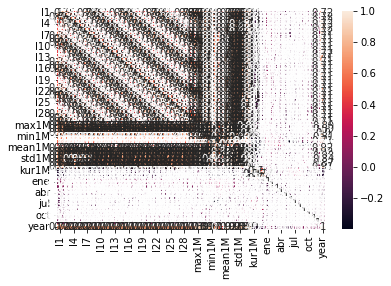

In [ ]:
sns.heatmap(Df_hobbies_final.loc[:,Df_hobbies_final.columns!='total_sales'].corr(), annot=True)
plt.show()

## Feature Engineering

### function

In [ ]:
def evaluation_models(X_train, X_valid, y_train, y_valid):
  param_grid = {'max_leaf_nodes': [10, 12,15,20], 
              'n_estimators': [100,150,200]}

  #rfgs = GridSearchCV(RandomForestRegressor(), cv=3, param_grid=param_grid)
  gbgs = GridSearchCV(GradientBoostingRegressor(), cv=3, param_grid=param_grid)
  #rfgs.fit(X_train,y_train)
  gbgs.fit(y_train,y_train)

  #rf=RandomForestRegressor(n_estimators=rfgs.best_params_['n_estimators'],max_leaf_nodes=rfgs.best_params_['max_leaf_nodes'])
  #rf.fit(X_train,y_train)
  gb=GradientBoostingRegressor(n_estimators=gbgs.best_params_['n_estimators'],max_leaf_nodes=gbgs.best_params_['max_leaf_nodes'])
  gb.fit(X_train,y_train)
  # print('MAE VALID RF')
  # print(mean_absolute_error(y_valid, rf.predict(X_valid)))
  print('MAE VALID GB')
  print(mean_absolute_error(y_valid, gb.predict(X_valid)))


In [ ]:
import warnings
warnings.filterwarnings("ignore")

### All features

In [ ]:
evaluation_models(X_train, X_valid, (y_train).values.reshape(-1,1), (y_valid).values.reshape(-1,1))

MAE VALID GB
570810.1163651086


### Corr Pearson

In [ ]:
mat_spearman = Df_hobbies_final.corr('pearson')
#Correlation with output variable
cor_target = abs(mat_spearman['total_sales'])
#Selecting highly correlated features
relevant_features = (cor_target[cor_target>0.75].to_frame().T).drop('total_sales', axis=1)
(relevant_features)

,l3,l10,l17,l24,mean1M,mean2M
total_sales,0.843107,0.838794,0.852872,0.860793,0.764612,0.755059


Evaluation

In [ ]:
evaluation_models(X_train.loc[:,['l3','l10','l17','l24','mean1M','mean2M']], 
                  X_valid.loc[:,['l3','l10','l17','l24','mean1M', 'mean2M']],
                  (y_train).values.reshape(-1,1), (y_valid).values.reshape(-1,1))

MAE VALID GB
565245.0616438997


### Corr Spearman

In [ ]:
mat_spearman = Df_hobbies_final.corr('spearman')
#Correlation with output variable
cor_target = abs(mat_spearman['total_sales'])
#Selecting highly correlated features
relevant_features = (cor_target[cor_target>0.75].to_frame().T).drop('total_sales', axis=1)
(relevant_features)

,l2,l3,l4,l9,l10,l11,l16,l17,l18,l23,l24,l25,l30,max1M,max6M,mean1M,mean2M,mean6M,year
total_sales,0.759496,0.852006,0.759751,0.761586,0.849255,0.762627,0.767229,0.866149,0.772324,0.76649,0.866491,0.769692,0.802626,0.752715,0.751752,0.785554,0.769119,0.757081,0.755055


**Evaluation**

In [ ]:
evaluation_models(X_train.loc[:,['l2','l3','l4','l9', 'l10', 'l11','l16','l17','l18','l23','l24','l25','l30','max1M','max6M','mean1M','mean2M','mean6M','year']], 
                  X_valid.loc[:,['l2','l3','l4','l9', 'l10', 'l11','l16','l17','l18','l23','l24','l25','l30','max1M','max6M','mean1M','mean2M','mean6M','year']], 
                  (y_train).values.reshape(-1,1), 
                  (y_valid).values.reshape(-1,1))

MAE VALID GB
605421.369661514


### RF Feature import

In [ ]:
rf = RandomForestRegressor(random_state=123)

rf.fit(dataStandarized,y)

RandomForestRegressor(random_state=123)

<Figure size 640x480 with 0 Axes>

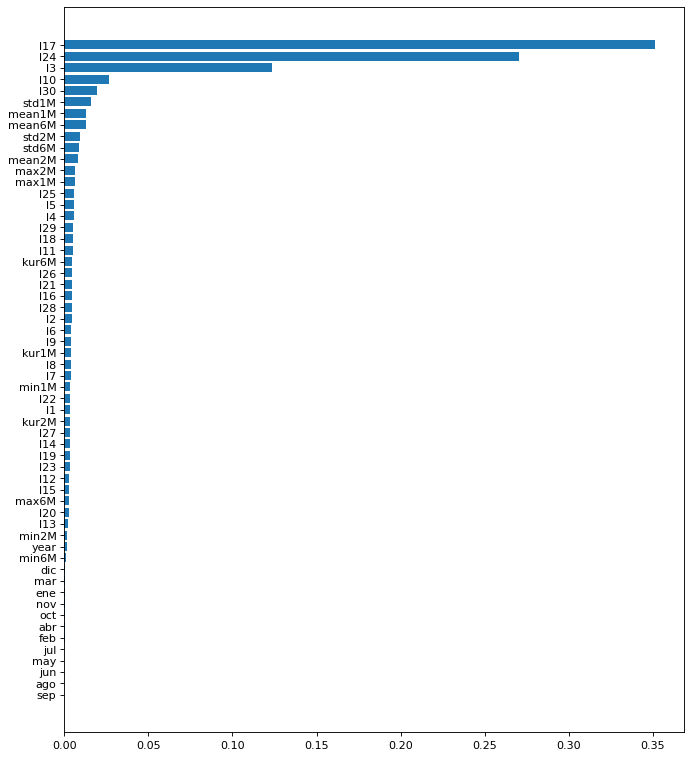

In [ ]:
f_i = list(zip(X_train.columns,rf.feature_importances_))
f_i.sort(key = lambda x : x[1])

figure(figsize=(8, 6), dpi=80)
figure(figsize=(10, 12), dpi=80)
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])

plt.show()

**Evaluation**

In [ ]:
evaluation_models(X_train.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']], X_valid.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']], (y_train).values.reshape(-1,1), (y_valid).values.reshape(-1,1))

MAE VALID GB
548057.2820278466


### Recursive Elimination

features = 5

In [ ]:
estimator = RandomForestRegressor(max_leaf_nodes= 12, max_features=2, n_estimators=100, random_state=123)
selector = RFE(estimator, n_features_to_select=7 ,step=1)
selector = selector.fit(dataStandarized, y.values)
print(selector.support_)
print(selector.ranking_)

[False False  True False False False False False False  True False False
 False False False False  True False False False False False False  True
 False False False False False  True False False False False False False
  True False  True False False False False False False False False False
 False False False False False False False False False False]
[34 11  1 17 31 20 22 18  7  1 14 26 29 32 36 13  1  6 19 27 37 33 10  1
  9 25 28 30 24  1  5  8  2 23 21 35  1  3  1 15  4 12 39 40 38 42 48 52
 50 49 46 43 41 45 47 51 44 16]


In [ ]:
ind =np.nonzero(selector.support_)[0]

In [ ]:
X_train.iloc[1,ind.tolist()]

l3       -0.896077
l10      -0.793656
l17      -0.495425
l24      -0.723013
l30      -0.391843
mean1M   -1.247201
mean6M   -1.196898
Name: 1, dtype: float64

Evaluation

In [ ]:
evaluation_models(X_train.iloc[:,ind.tolist()], X_valid.iloc[:,ind.tolist()], (y_train).values.reshape(-1,1), (y_valid).values.reshape(-1,1))

MAE VALID GB
557119.606660158


features = 3

In [ ]:
estimator = RandomForestRegressor(max_leaf_nodes= 12, max_features=2, n_estimators=100, random_state=123)
selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(dataStandarized, y.values)
print(selector.support_)
print(selector.ranking_)

[False False False  True  True False False False False  True False False]
[ 9  6  2  1  1  4  7  8  5  1 10  3]


In [ ]:
evaluation_models(X_train.iloc[:,[3,4,9]], X_valid.iloc[:,[3,4,9]], (y_train).values.reshape(-1,1), (y_valid).values.reshape(-1,1))

MAE VALID RF
499324.79712458135
MAE VALID GB
494394.4652334016


### Backward "Sequential feature selection"

In [ ]:
#Primera iteración
sfs = SequentialFeatureSelector(LinearRegression())
sfs.fit(dataStandarized, y)
ind =np.nonzero(sfs.get_support())[0]
print(sfs.get_support())
Xstandarized[:,ind].shape

[ True False  True  True False  True  True  True  True  True  True  True
 False  True False False  True  True False  True  True  True False  True
 False False False  True False  True False False  True False False  True
  True False False False False  True False False  True False  True False
 False False False  True False False False  True  True  True]


(1696, 29)

In [ ]:
(sfs.get_support())

array([False, False,  True,  True, False, False, False,  True,  True,
        True,  True,  True, False,  True, False, False,  True,  True,
       False,  True,  True,  True, False,  True, False, False, False,
        True, False,  True,  True,  True,  True,  True, False,  True,
        True, False, False, False, False, False, False, False, False,
       False,  True])

In [ ]:
X_train.iloc[1,ind.tolist()]

l1       -1.168808
l3       -0.896077
l4       -0.995083
l6       -0.984732
l7       -1.166340
l8       -0.907205
l9       -0.401039
l10      -0.793656
l11      -1.309575
l12      -1.163733
l14      -1.319650
l17      -0.495425
l18      -0.994648
l20      -1.334888
l21      -1.283531
l22      -1.102057
l24      -0.723013
l28      -1.343489
l30      -0.391843
max6M    -1.531105
min6M    -0.451956
mean1M   -1.247201
std6M    -1.414090
kur6M    -0.466339
feb      -0.302286
jul      -0.280857
nov      -0.311488
dic      -0.311488
year     -1.773755
Name: 1, dtype: float64

Evaluation

In [ ]:
evaluation_models(X_train.iloc[:,ind.tolist()],X_valid.iloc[:,ind.tolist()],y_train.values.reshape(-1, 1),y_valid.values.reshape(-1, 1))

MAE VALID GB
653624.0818599346


## **Test Performance**

### kNN

In [ ]:
knn = KNeighborsRegressor(n_neighbors=24)
knn.fit(dataScaled.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']], yscaled)

KNeighborsRegressor(n_neighbors=24)

In [ ]:
X_df_test=Df_hobbies_final.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']].reset_index(drop=True)
y_df_test=Df_hobbies_final['total_sales'].reset_index(drop=True)

For Loop

In [ ]:
for i in range(0,30):
  last180=y_df_test.iloc[-180:]
  newX=[]
  newX.append(last180.iloc[-30:].iloc[16]) #l 17
  newX.append(last180.iloc[-30:].iloc[23])  #l 24
  newX.append(last180.iloc[-30:].iloc[12])  #l 13
  newX.append(last180.iloc[-30:].iloc[9])   #l 10
  newX.append(last180.iloc[-30:].iloc[29])  #l 30
  newX.append(last180.iloc[30:].std())   #Std 1M
  newX.append(last180.iloc[30:].mean())   #mean 1M
  newX.append(last180.iloc[60:].std())   #Std 2M
  newX.append(last180.values.mean())   #mean 6M
  X_df_test.loc[len(X_df_test)] = newX

  #Final Prediction with test
  scaled= scaler.fit_transform(X_df_test)
  prediction = ( knn.predict(scaled[-1:]).reshape(-1,1) )
  finalPrediction = scaler.inverse_transform(np.vstack([ scaler.fit_transform(Df_hobbies_final['total_sales'].values.reshape(-1, 1)) , prediction] ))
  y_df_test.loc[len(y_df_test)]=finalPrediction[-1][0] # The last predictions are the final Testing predictions

In [ ]:
print('MAE TEST:', mean_absolute_error(y_test.values,  y_df_test[-30:].values))

MAE TEST: 999664.9115416667


### RF

In [ ]:
rf=RandomForestRegressor(n_estimators= 100, max_features= 6, max_leaf_nodes=25)
rf.fit(dataScaled.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']], yscaled)

RandomForestRegressor(max_features=6, max_leaf_nodes=25)

In [ ]:
X_df_test=Df_hobbies_final.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']].reset_index(drop=True)
y_df_test=Df_hobbies_final['total_sales'].reset_index(drop=True)

For Loop

In [ ]:
for i in range(0,30):
  last180=y_df_test.iloc[-180:]
  newX=[]
  newX.append(last180.iloc[-30:].iloc[16]) #l 17
  newX.append(last180.iloc[-30:].iloc[23])  #l 24
  newX.append(last180.iloc[-30:].iloc[12])  #l 13
  newX.append(last180.iloc[-30:].iloc[9])   #l 10
  newX.append(last180.iloc[-30:].iloc[29])  #l 30
  newX.append(last180.iloc[30:].std())   #Std 1M
  newX.append(last180.iloc[30:].mean())   #mean 1M
  newX.append(last180.iloc[60:].std())   #Std 2M
  newX.append(last180.values.mean())   #mean 6M
  X_df_test.loc[len(X_df_test)] = newX

  #Final Prediction with test
  scaled= scaler.fit_transform(X_df_test)
  prediction = ( rf.predict(scaled[-1:]).reshape(-1,1) )
  finalPrediction = scaler.inverse_transform(np.vstack([ scaler.fit_transform(Df_hobbies_final['total_sales'].values.reshape(-1, 1)) , prediction] ))
  y_df_test.loc[len(y_df_test)]=finalPrediction[-1][0] # The last predictions are the final Testing predictions

In [ ]:
print('MAE TEST:', mean_absolute_error(y_test.values,  y_df_test[-30:].values))

MAE TEST: 892586.0097246998


Grafico Predictions and Y real

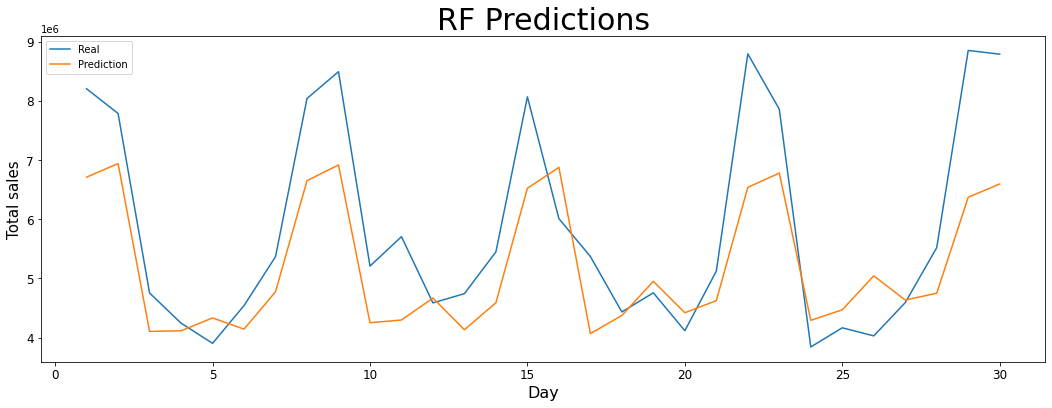

In [ ]:
plt.figure(figsize=(18, 6))
plt.xlabel('Day',fontsize=16)
plt.ylabel('Total sales',fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('RF Predictions',fontsize=30)
plt.plot(range(1,31),y_test.values, label = "Real")
plt.plot(range(1,31),y_df_test[-30:].values, label = "Prediction")
plt.legend()
plt.show()

### Gradient Boosting

In [ ]:
gb=GradientBoostingRegressor(n_estimators = 50, max_features=6, max_leaf_nodes=20)
gb.fit(dataScaled.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']], yscaled)

GradientBoostingRegressor(max_features=6, max_leaf_nodes=20, n_estimators=50)

In [ ]:
X_df_test=Df_hobbies_final.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']].reset_index(drop=True)
y_df_test=Df_hobbies_final['total_sales'].reset_index(drop=True)

For Loop

In [ ]:
for i in range(0,30):
  last180=y_df_test.iloc[-180:]
  newX=[]
  newX.append(last180.iloc[-30:].iloc[16]) #l 17
  newX.append(last180.iloc[-30:].iloc[23])  #l 24
  newX.append(last180.iloc[-30:].iloc[12])  #l 13
  newX.append(last180.iloc[-30:].iloc[9])   #l 10
  newX.append(last180.iloc[-30:].iloc[29])  #l 30
  newX.append(last180.iloc[30:].std())   #Std 1M
  newX.append(last180.iloc[30:].mean())   #mean 1M
  newX.append(last180.iloc[60:].std())   #Std 2M
  newX.append(last180.values.mean())   #mean 6M
  X_df_test.loc[len(X_df_test)] = newX

  #Final Prediction with test
  scaled= scaler.fit_transform(X_df_test)
  prediction = ( gb.predict(scaled[-1:]).reshape(-1,1) )
  finalPrediction = scaler.inverse_transform(np.vstack([ scaler.fit_transform(Df_hobbies_final['total_sales'].values.reshape(-1, 1)) , prediction] ))
  y_df_test.loc[len(y_df_test)]=finalPrediction[-1][0] # The last predictions are the final Testing predictions

In [ ]:
print('MAE TEST:', mean_absolute_error(y_test.values,  y_df_test[-30:].values))

MAE TEST: 926338.8972503449


### SVR

In [ ]:
regressor = SVR(kernel ='poly', C=500, degree=2)
regressor.fit(X_trainScaled.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']], y_trainScaled[:,0])

SVR(C=500, kernel='poly')

In [ ]:
X_df_test=Df_hobbies_final.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']].reset_index(drop=True)
y_df_test=Df_hobbies_final['total_sales'].reset_index(drop=True)

For Loop

In [ ]:
for i in range(0,30):
  last180=y_df_test.iloc[-180:]
  newX=[]
  newX.append(last180.iloc[-30:].iloc[16]) #l 17
  newX.append(last180.iloc[-30:].iloc[23])  #l 24
  newX.append(last180.iloc[-30:].iloc[12])  #l 13
  newX.append(last180.iloc[-30:].iloc[9])   #l 10
  newX.append(last180.iloc[-30:].iloc[29])  #l 30
  newX.append(last180.iloc[30:].std())   #Std 1M
  newX.append(last180.iloc[30:].mean())   #mean 1M
  newX.append(last180.iloc[60:].std())   #Std 2M
  newX.append(last180.values.mean())   #mean 6M
  X_df_test.loc[len(X_df_test)] = newX

  #Final Prediction with test
  scaled= scaler.fit_transform(X_df_test)
  prediction = ( regressor.predict(scaled[-1:]).reshape(-1,1) )
  finalPrediction = scaler.inverse_transform(np.vstack([ scaler.fit_transform(Df_hobbies_final['total_sales'].values.reshape(-1, 1)) , prediction] ))
  y_df_test.loc[len(y_df_test)]=finalPrediction[-1][0] # The last predictions are the final Testing predictions

In [ ]:
print('MAE TEST:', mean_absolute_error(y_test.values,  y_df_test[-30:].values))

MAE TEST: 4363953.71571502


### RF-kNN - J.J

In [ ]:
rf_knn = RF_KNN( n_trees = 35,  max_leaf_nodes = 2,  max_features = 9,  n_neighbors = 24,p=1)
rf_knn.fit(dataScaled.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']], yscaled)

Training the kNN classifiers:


100%|██████████| 70/70 [00:02<00:00, 34.90it/s]


In [ ]:
X_df_test=Df_hobbies_final.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']].reset_index(drop=True)
y_df_test=Df_hobbies_final['total_sales'].reset_index(drop=True)

For Loop

In [ ]:
for i in range(0,30):
  last180=y_df_test.iloc[-180:]
  newX=[]
  newX.append(last180.iloc[-30:].iloc[16]) #l 17
  newX.append(last180.iloc[-30:].iloc[23])  #l 24
  newX.append(last180.iloc[-30:].iloc[12])  #l 13
  newX.append(last180.iloc[-30:].iloc[9])   #l 10
  newX.append(last180.iloc[-30:].iloc[29])  #l 30
  newX.append(last180.iloc[30:].std())   #Std 1M
  newX.append(last180.iloc[30:].mean())   #mean 1M
  newX.append(last180.iloc[60:].std())   #Std 2M
  newX.append(last180.values.mean())   #mean 6M
  X_df_test.loc[len(X_df_test)] = newX

  #Final Prediction with test
  scaled= scaler.fit_transform(X_df_test)
  prediction = ( rf_knn.predict(scaled[-1:]).reshape(-1,1) )
  finalPrediction = scaler.inverse_transform(np.vstack([ scaler.fit_transform(Df_hobbies_final['total_sales'].values.reshape(-1, 1)) , prediction] ))
  y_df_test.loc[len(y_df_test)]=finalPrediction[-1][0] # The last predictions are the final Testing predictions

Predicting with the kNN classifiers:


100%|██████████| 35/35 [00:00<00:00, 1292.89it/s]


Predicting with the kNN classifiers:


100%|██████████| 35/35 [00:00<00:00, 1506.81it/s]


Predicting with the kNN classifiers:


100%|██████████| 35/35 [00:00<00:00, 1568.11it/s]


Predicting with the kNN classifiers:


100%|██████████| 35/35 [00:00<00:00, 1703.56it/s]


Predicting with the kNN classifiers:


100%|██████████| 35/35 [00:00<00:00, 1179.71it/s]


Predicting with the kNN classifiers:


100%|██████████| 35/35 [00:00<00:00, 1655.17it/s]


Predicting with the kNN classifiers:


100%|██████████| 35/35 [00:00<00:00, 1269.98it/s]


Predicting with the kNN classifiers:


100%|██████████| 35/35 [00:00<00:00, 1146.30it/s]


Predicting with the kNN classifiers:


100%|██████████| 35/35 [00:00<00:00, 1643.59it/s]


Predicting with the kNN classifiers:


100%|██████████| 35/35 [00:00<00:00, 1310.87it/s]


Predicting with the kNN classifiers:


100%|██████████| 35/35 [00:00<00:00, 1680.26it/s]


Predicting with the kNN classifiers:


100%|██████████| 35/35 [00:00<00:00, 1545.97it/s]


Predicting with the kNN classifiers:


100%|██████████| 35/35 [00:00<00:00, 1547.97it/s]


Predicting with the kNN classifiers:


100%|██████████| 35/35 [00:00<00:00, 1485.78it/s]


Predicting with the kNN classifiers:


100%|██████████| 35/35 [00:00<00:00, 1422.86it/s]


Predicting with the kNN classifiers:


100%|██████████| 35/35 [00:00<00:00, 1408.77it/s]


Predicting with the kNN classifiers:


100%|██████████| 35/35 [00:00<00:00, 1130.51it/s]


Predicting with the kNN classifiers:


100%|██████████| 35/35 [00:00<00:00, 1715.80it/s]


Predicting with the kNN classifiers:


100%|██████████| 35/35 [00:00<00:00, 1159.38it/s]


Predicting with the kNN classifiers:


100%|██████████| 35/35 [00:00<00:00, 1247.32it/s]


Predicting with the kNN classifiers:


100%|██████████| 35/35 [00:00<00:00, 1565.01it/s]


Predicting with the kNN classifiers:


100%|██████████| 35/35 [00:00<00:00, 1332.32it/s]


Predicting with the kNN classifiers:


100%|██████████| 35/35 [00:00<00:00, 1234.31it/s]


Predicting with the kNN classifiers:


100%|██████████| 35/35 [00:00<00:00, 1635.81it/s]


Predicting with the kNN classifiers:


100%|██████████| 35/35 [00:00<00:00, 1267.06it/s]


Predicting with the kNN classifiers:


100%|██████████| 35/35 [00:00<00:00, 1273.11it/s]


Predicting with the kNN classifiers:


100%|██████████| 35/35 [00:00<00:00, 1105.18it/s]


Predicting with the kNN classifiers:


100%|██████████| 35/35 [00:00<00:00, 1239.65it/s]


Predicting with the kNN classifiers:


100%|██████████| 35/35 [00:00<00:00, 1499.20it/s]


Predicting with the kNN classifiers:


100%|██████████| 35/35 [00:00<00:00, 1512.80it/s]


In [ ]:
print('MAE TEST:', mean_absolute_error(y_test.values,  y_df_test[-30:].values))

MAE TEST: 985482.7465099207


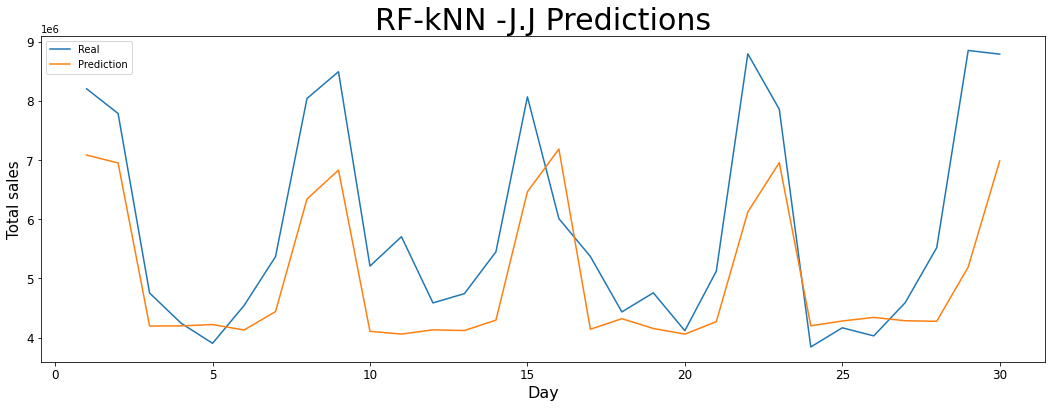

In [ ]:
plt.figure(figsize=(18, 6))
plt.xlabel('Day',fontsize=16)
plt.ylabel('Total sales',fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('RF-kNN -J.J Predictions',fontsize=30)
plt.plot(range(1,31),y_test.values, label = "Real")
plt.plot(range(1,31),y_df_test[-30:].values, label = "Prediction")
plt.legend()
plt.show()